In [20]:
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

### LightGBM

In [21]:
df_train = pd.read_csv('../data/train_con_features_encoded.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('../data/test_con_features_encoded.csv', index_col='Unnamed: 0')
display(df_train.head())

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,...,precio_prom_ciudad,precio_prom_propiedad,cantidad_palabras_descripcion,relacion_palabras_descripcion,ciudad_turistica_top15,anio,mes,tipodepropiedad_cb,ciudad_cb,provincia_cb
0,254099,8.116114,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,...,3.384659e+06,2.763769e+06,0,0.000000,0,2015,8,2.763765e+06,3.384582e+06,3.471689e+06
1,53461,10.000000,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,...,4.605869e+06,2.898927e+06,1,0.007968,0,2013,6,2.898908e+06,4.604780e+06,3.471689e+06
2,247984,5.000000,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,...,8.870115e+05,2.398158e+06,10,0.046957,0,2015,10,2.398159e+06,8.890818e+05,2.367701e+06
3,209067,1.000000,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,...,1.472305e+06,2.398158e+06,0,0.000000,0,2012,3,2.398159e+06,1.479134e+06,2.762459e+06
4,185997,10.000000,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,...,2.749675e+06,2.763769e+06,1,0.074108,0,2016,6,2.763765e+06,2.749654e+06,2.367701e+06


In [22]:
#Guardo y remuevo la columna id de los datos
id_col = df_test['id']
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

#Separo features de entrenamiento del precio
feature_cols = df_train.columns.tolist()
feature_cols.remove('precio')


X = df_train[feature_cols]
y = df_train['precio']

feature_cols

['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(180000, 29) (180000,)
(60000, 29) (60000,)


In [24]:
import lightgbm as lgb
from sklearn import metrics

'''clf = lgb.LGBMRegressor()

#ajustar
gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'min_data_in_leaf':[10],
    'metric':['mae']
    }

grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)
grid.fit(X_train,y_train)

grid.best_params_'''

"clf = lgb.LGBMRegressor()\n\n#ajustar\ngridParams = {\n    'learning_rate': [0.05],\n    'num_leaves': [90,200],\n    'boosting_type' : ['gbdt'],\n    'objective' : ['regression'],\n    'max_depth' : [5,6,7,8],\n    'random_state' : [501], \n    'colsample_bytree' : [0.5,0.7],\n    'min_data_in_leaf':[10],\n    'metric':['mae']\n    }\n\ngrid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=10)\ngrid.fit(X_train,y_train)\n\ngrid.best_params_"

In [25]:
best_params = {
    'learning_rate': 0.04,      #best=0.04   
    'num_leaves': 512,          #best=512    MAE=522286  CATBOOST ENCODED ---> k=30
    'max_depth' : 12,           #best=12     MAE=521761  CATBOOST(ciudades) + ONE HOT ENCODED ---> k=100
    'objective' : 'regression', #            
    'max_depth' : 12,           #best=12
    'random_state' : 501,       #best=501
    'colsample_bytree' : 0.5,   #best=0.5
    'min_data_in_leaf':10,      #best=10
    'metric':['mae']
    }

In [26]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

LightGBM = lgb.train(best_params, lgb_train, num_boost_round=1500, valid_sets=lgb_eval, early_stopping_rounds=10)

[1]	valid_0's l1: 1.5779e+06
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 1.533e+06
[3]	valid_0's l1: 1.48839e+06
[4]	valid_0's l1: 1.4456e+06
[5]	valid_0's l1: 1.40497e+06
[6]	valid_0's l1: 1.3661e+06
[7]	valid_0's l1: 1.32922e+06
[8]	valid_0's l1: 1.29274e+06
[9]	valid_0's l1: 1.26416e+06
[10]	valid_0's l1: 1.2311e+06
[11]	valid_0's l1: 1.20059e+06
[12]	valid_0's l1: 1.17096e+06
[13]	valid_0's l1: 1.14376e+06
[14]	valid_0's l1: 1.11725e+06
[15]	valid_0's l1: 1.09328e+06
[16]	valid_0's l1: 1.06942e+06
[17]	valid_0's l1: 1.04674e+06
[18]	valid_0's l1: 1.02491e+06
[19]	valid_0's l1: 1.00433e+06
[20]	valid_0's l1: 983628
[21]	valid_0's l1: 964453
[22]	valid_0's l1: 945868
[23]	valid_0's l1: 928929
[24]	valid_0's l1: 912157
[25]	valid_0's l1: 896897
[26]	valid_0's l1: 882908
[27]	valid_0's l1: 869323
[28]	valid_0's l1: 857429
[29]	valid_0's l1: 844896
[30]	valid_0's l1: 832283
[31]	valid_0's l1: 820562
[32]	valid_0's l1: 810704
[33]	valid_0's l1: 800465
[

[303]	valid_0's l1: 545028
[304]	valid_0's l1: 544934
[305]	valid_0's l1: 544781
[306]	valid_0's l1: 544725
[307]	valid_0's l1: 544583
[308]	valid_0's l1: 544446
[309]	valid_0's l1: 544366
[310]	valid_0's l1: 544286
[311]	valid_0's l1: 544175
[312]	valid_0's l1: 544120
[313]	valid_0's l1: 544038
[314]	valid_0's l1: 543980
[315]	valid_0's l1: 543952
[316]	valid_0's l1: 543938
[317]	valid_0's l1: 543914
[318]	valid_0's l1: 543886
[319]	valid_0's l1: 543780
[320]	valid_0's l1: 543758
[321]	valid_0's l1: 543624
[322]	valid_0's l1: 543556
[323]	valid_0's l1: 543517
[324]	valid_0's l1: 543417
[325]	valid_0's l1: 543367
[326]	valid_0's l1: 543310
[327]	valid_0's l1: 543177
[328]	valid_0's l1: 543091
[329]	valid_0's l1: 543054
[330]	valid_0's l1: 542964
[331]	valid_0's l1: 542947
[332]	valid_0's l1: 542885
[333]	valid_0's l1: 542856
[334]	valid_0's l1: 542820
[335]	valid_0's l1: 542745
[336]	valid_0's l1: 542708
[337]	valid_0's l1: 542598
[338]	valid_0's l1: 542569
[339]	valid_0's l1: 542462
[

[611]	valid_0's l1: 531800
[612]	valid_0's l1: 531805
[613]	valid_0's l1: 531796
[614]	valid_0's l1: 531771
[615]	valid_0's l1: 531753
[616]	valid_0's l1: 531737
[617]	valid_0's l1: 531735
[618]	valid_0's l1: 531723
[619]	valid_0's l1: 531707
[620]	valid_0's l1: 531691
[621]	valid_0's l1: 531657
[622]	valid_0's l1: 531645
[623]	valid_0's l1: 531628
[624]	valid_0's l1: 531625
[625]	valid_0's l1: 531546
[626]	valid_0's l1: 531522
[627]	valid_0's l1: 531522
[628]	valid_0's l1: 531504
[629]	valid_0's l1: 531480
[630]	valid_0's l1: 531455
[631]	valid_0's l1: 531388
[632]	valid_0's l1: 531375
[633]	valid_0's l1: 531367
[634]	valid_0's l1: 531349
[635]	valid_0's l1: 531344
[636]	valid_0's l1: 531272
[637]	valid_0's l1: 531229
[638]	valid_0's l1: 531213
[639]	valid_0's l1: 531187
[640]	valid_0's l1: 531159
[641]	valid_0's l1: 531137
[642]	valid_0's l1: 531117
[643]	valid_0's l1: 531109
[644]	valid_0's l1: 531110
[645]	valid_0's l1: 531052
[646]	valid_0's l1: 531046
[647]	valid_0's l1: 530976
[

[916]	valid_0's l1: 526466
[917]	valid_0's l1: 526448
[918]	valid_0's l1: 526412
[919]	valid_0's l1: 526394
[920]	valid_0's l1: 526386
[921]	valid_0's l1: 526394
[922]	valid_0's l1: 526372
[923]	valid_0's l1: 526364
[924]	valid_0's l1: 526351
[925]	valid_0's l1: 526341
[926]	valid_0's l1: 526321
[927]	valid_0's l1: 526295
[928]	valid_0's l1: 526270
[929]	valid_0's l1: 526252
[930]	valid_0's l1: 526243
[931]	valid_0's l1: 526249
[932]	valid_0's l1: 526227
[933]	valid_0's l1: 526231
[934]	valid_0's l1: 526220
[935]	valid_0's l1: 526209
[936]	valid_0's l1: 526206
[937]	valid_0's l1: 526188
[938]	valid_0's l1: 526185
[939]	valid_0's l1: 526178
[940]	valid_0's l1: 526154
[941]	valid_0's l1: 526158
[942]	valid_0's l1: 526158
[943]	valid_0's l1: 526154
[944]	valid_0's l1: 526154
[945]	valid_0's l1: 526149
[946]	valid_0's l1: 526132
[947]	valid_0's l1: 526133
[948]	valid_0's l1: 526117
[949]	valid_0's l1: 526111
[950]	valid_0's l1: 526113
[951]	valid_0's l1: 526104
[952]	valid_0's l1: 526102
[

[1216]	valid_0's l1: 523758
[1217]	valid_0's l1: 523764
[1218]	valid_0's l1: 523761
[1219]	valid_0's l1: 523749
[1220]	valid_0's l1: 523740
[1221]	valid_0's l1: 523730
[1222]	valid_0's l1: 523716
[1223]	valid_0's l1: 523713
[1224]	valid_0's l1: 523715
[1225]	valid_0's l1: 523703
[1226]	valid_0's l1: 523708
[1227]	valid_0's l1: 523693
[1228]	valid_0's l1: 523688
[1229]	valid_0's l1: 523691
[1230]	valid_0's l1: 523685
[1231]	valid_0's l1: 523681
[1232]	valid_0's l1: 523671
[1233]	valid_0's l1: 523675
[1234]	valid_0's l1: 523658
[1235]	valid_0's l1: 523652
[1236]	valid_0's l1: 523641
[1237]	valid_0's l1: 523617
[1238]	valid_0's l1: 523606
[1239]	valid_0's l1: 523598
[1240]	valid_0's l1: 523589
[1241]	valid_0's l1: 523576
[1242]	valid_0's l1: 523563
[1243]	valid_0's l1: 523557
[1244]	valid_0's l1: 523561
[1245]	valid_0's l1: 523560
[1246]	valid_0's l1: 523549
[1247]	valid_0's l1: 523550
[1248]	valid_0's l1: 523547
[1249]	valid_0's l1: 523547
[1250]	valid_0's l1: 523547
[1251]	valid_0's l1:

In [27]:
LightGBM_pred = LightGBM.predict(X_test, num_iteration=LightGBM.best_iteration)

In [28]:
from sklearn.metrics import mean_absolute_error

LightGBM_mae = mean_absolute_error(y_test, LightGBM_pred)
LightGBM_mae_train = mean_absolute_error(y_train, LightGBM.predict(X_train, num_iteration=LightGBM.best_iteration))
print(f"LightGBM (train): {LightGBM_mae_train:.5f}")
print(f"LightGBM: {LightGBM_mae:.5f}")
print("------------------------------")

LightGBM (train): 250228.51103
LightGBM: 522286.09996
------------------------------


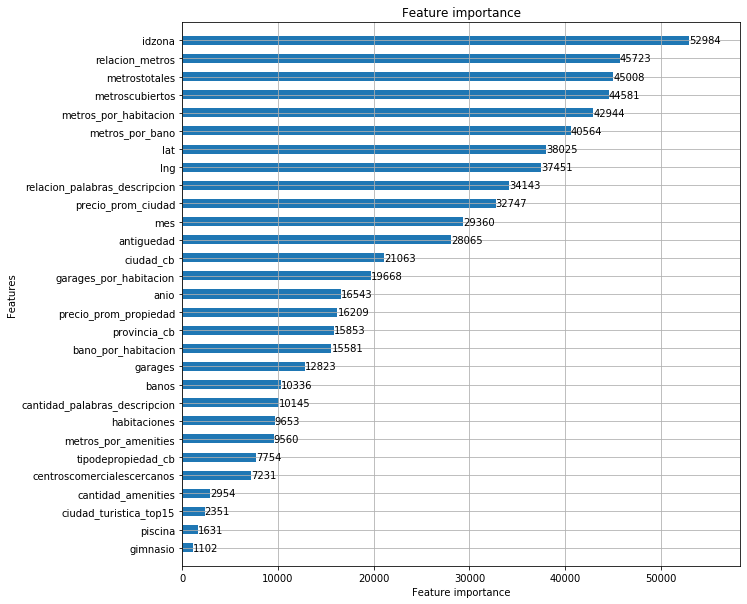

In [29]:
ax = lgb.plot_importance(LightGBM, height=0.5)
fig = ax.figure
fig.set_size_inches(10, 10)

In [30]:
LightGBM_pred_submit = LightGBM.predict(df_test, num_iteration=LightGBM.best_iteration)

In [31]:
resultado_submit = pd.DataFrame(index=df_test.index)
resultado_submit['id'] = id_col
resultado_submit['target'] = LightGBM_pred_submit
display(resultado_submit.head())
resultado_submit.to_csv('../data/submitLightGBM.csv',index=False)

,id,target
0,4941,7.577310e+06
1,51775,1.020897e+06
2,115253,2.371400e+06
3,299321,1.431120e+06
4,173570,5.815521e+05


#### Score en Kaggle (features => score):
 **1.** ***Usando CatBoost encoded*** y ['id',
 'antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'cantidad_servicios',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'provincia_top5',
 'seguridad_descripcion',
 'moderno_descripcion',
 'hermoso_descripcion',
 'estado_descripcion',
 'seguridad_titulo',
 'moderno_titulo',
 'hermoso_titulo',
 'estado_titulo',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'es_avenida',
 'es_ciudad_capital',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***573846.94092*** con 'learning_rate': 0.03,
    'num_leaves': 256,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.7,
    'subsample' : 0.7,
    'min_split_gain' : 0.01,
    'min_data_in_leaf':10,
***LOCAL MAE: 568518.75474***

 **2.** ***Usando CatBoost encoded y k=30*** y ['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'piscina',
 'centroscomercialescercanos',
 'cantidad_amenities',
 'relacion_metros',
 'metros_por_habitacion',
 'metros_por_bano',
 'metros_por_amenities',
 'bano_por_habitacion',
 'garages_por_habitacion',
 'precio_prom_ciudad',
 'precio_prom_propiedad',
 'cantidad_palabras_descripcion',
 'relacion_palabras_descripcion',
 'ciudad_turistica_top15',
 'anio',
 'mes',
 'tipodepropiedad_cb',
 'ciudad_cb',
 'provincia_cb']=> ***532012.21935*** con 'learning_rate': 0.04,
    'num_leaves': 512,
    'objective' : 'regression',
    'max_depth' : 12,
    'random_state' : 501, 
    'colsample_bytree' : 0.5,
    'min_data_in_leaf':10,
***LOCAL MAE: 522286.09996***